In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# 1. Install pysr library
# !pip install -q pysr

# 2. Import and execute julia installation (This step takes a bit of time on Kaggle, about 2-3 minutes)
# import pysr
# pysr.install()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

DATA_DIR = "/"
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")
sample_path = os.path.join(DATA_DIR, "sample_submission.csv")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
sample_df = pd.read_csv(sample_path)

Device: cuda


In [30]:
# --- Paste at the beginning of Cell 2 ---
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import KBinsDiscretizer

# A. Calculate KNN features (used to capture local patterns)
knn_reg = KNeighborsRegressor(n_neighbors=15, weights='distance', n_jobs=-1)
# Training set prediction (use K-Fold to avoid leakage)
train_df['knn_pred'] = np.nan
kf_knn = KFold(n_splits=5, shuffle=True, random_state=42)
for tr_idx, va_idx in kf_knn.split(train_df):
    knn_reg.fit(train_df.loc[tr_idx, ['x1', 'x2']], train_df.loc[tr_idx, 'y'])
    train_df.loc[va_idx, 'knn_pred'] = knn_reg.predict(train_df.loc[va_idx, ['x1', 'x2']])
# Test set prediction
knn_reg.fit(train_df[['x1', 'x2']], train_df['y'])
test_df['knn_pred'] = knn_reg.predict(test_df[['x1', 'x2']])

# B. Calculate Target Encoding (r_te)
discretizer = KBinsDiscretizer(n_bins=200, encode='ordinal', strategy='quantile')
train_df['r'] = np.sqrt(train_df['x1']**2 + train_df['x2']**2)
test_df['r'] = np.sqrt(test_df['x1']**2 + test_df['x2']**2)
# Add .reshape(-1) to make it 1D, so that map will work
train_df['r_bin'] = discretizer.fit_transform(train_df[['r']]).reshape(-1).astype(int)
test_df['r_bin'] = discretizer.transform(test_df[['r']]).reshape(-1).astype(int)

# Training set r_te
train_df['r_te'] = np.nan
for tr_idx, va_idx in kf_knn.split(train_df):
    bin_means = train_df.loc[tr_idx].groupby('r_bin')['y'].mean()
    train_df.loc[va_idx, 'r_te'] = train_df.loc[va_idx, 'r_bin'].map(bin_means)
# Test set r_te
final_bin_means = train_df.groupby('r_bin')['y'].mean()
test_df['r_te'] = test_df['r_bin'].map(final_bin_means)

In [31]:
def get_pysr_feature(df):
    # This is the Python code converted from your Hall of Fame line 12
    # Note: In PySR, x0 is x1, and x1 is x2
    x1 = df['x1']
    x2 = df['x2']

    # 公式：square(cos((((0.014435811 - square(x0)) - square(x1)) * 3.0000703) - -0.7421232)) + 0.50067115
    inner = ((0.014435811 - x1**2 - x2**2) * 3.0000703) + 0.7421232
    feature = np.cos(inner)**2 + 0.50067115

    return feature

In [32]:
def apply_all_features(df):
    # 1. Basic Geometry
    df['r'] = np.sqrt(df['x1']**2 + df['x2']**2)
    df['angle'] = np.arctan2(df['x2'], df['x1'])

    # 2. Frequency Expansion
    df['wave_9_1'] = np.sin(df['r'] * 9.1)
    df['wave_7_3'] = np.cos(df['r'] * 7.3)

    # 3. Your formula (Ensure this function exists!)
    df['sr_feature'] = get_pysr_feature(df)

    return df

# --- Key Fix: Execute it! ---
train_df = apply_all_features(train_df)
test_df = apply_all_features(test_df)

# Final feature combination
features_final = ['sr_feature', 'knn_pred', 'r_te', 'wave_9_1', 'wave_7_3', 'angle']

In [33]:
# Define custom Dataset for PyTorch
class XYDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

# Prepare features and targets
X = train_df[features_final].values.astype(np.float32)
y = train_df[["y"]].values.astype(np.float32)
X_test = test_df[features_final].values.astype(np.float32)

# Split data into training and validation sets
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Feature scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_tr = scaler_x.fit_transform(X_tr)
X_va = scaler_x.transform(X_va)
X_test_s = scaler_x.transform(X_test)

y_tr = scaler_y.fit_transform(y_tr)
y_va = scaler_y.transform(y_va)

# Create DataLoaders
train_loader = DataLoader(XYDataset(X_tr, y_tr), batch_size=128, shuffle=True)
val_loader   = DataLoader(XYDataset(X_va, y_va), batch_size=256, shuffle=False)
test_loader  = DataLoader(XYDataset(X_test_s, None), batch_size=256, shuffle=False)

In [34]:
# Simple Residual Block with BatchNorm and SiLU activation
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.SiLU(),
        )
    def forward(self, x):
        return x + self.block(x)

# Deep MLP model with Residual connections
class ResDeepMLP(nn.Module):
    def __init__(self, in_dim=len(features_final), hidden_dim=128):
        super().__init__()
        self.input_layer = nn.Sequential(nn.Linear(in_dim, hidden_dim), nn.SiLU())
        self.res1 = ResidualBlock(hidden_dim)
        self.res2 = ResidualBlock(hidden_dim)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.SiLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res1(x)
        x = self.res2(x)
        return self.output_layer(x)

In [35]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
test_preds_all = []

# Re-acquire X, ensure dimension is 6
X = train_df[features_final].values.astype(np.float32)
y = train_df[["y"]].values.astype(np.float32)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold + 1} / {n_splits} =====")

    X_tr_f, X_va_f = X[train_idx], X[val_idx]
    y_tr_f, y_va_f = y[train_idx], y[val_idx]

    sc_x, sc_y = StandardScaler(), StandardScaler()
    X_tr_s = sc_x.fit_transform(X_tr_f)
    X_va_s = sc_x.transform(X_va_f)
    X_te_s = sc_x.transform(X_test) # X_test also needs to be updated synchronously
    y_tr_s = sc_y.fit_transform(y_tr_f)
    y_va_s = sc_y.transform(y_va_f)

    train_loader = DataLoader(XYDataset(X_tr_s, y_tr_s), batch_size=16, shuffle=True)
    val_loader   = DataLoader(XYDataset(X_va_s, y_va_s), batch_size=256, shuffle=False)

    best_val_fold = float("inf")
    best_state_fold = None
    wait = 0
    PATIENCE = 100
    EPOCHS = 500

    # 1. Slightly widen the model, but reduce residual blocks to increase calculation speed
    model = ResDeepMLP(in_dim=len(features_final), hidden_dim=256).to(device)

    # 2. Increase the initial learning rate to make it rush faster in the early stage
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-5)

    # 3. Adjust SGDR frequency: T_0 shortened, bounce more frequently
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=25, T_mult=1, eta_min=1e-8
    )

    # 4. Data loading: suppress batch_size to 16
    train_loader = DataLoader(XYDataset(X_tr_s, y_tr_s), batch_size=16, shuffle=True)
    criterion = nn.MSELoss()

    for epoch in range(1, EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_losses.append(criterion(model(xb), yb).item())

        # --- Correction: Ensure va_loss is correctly defined ---
        va_loss = np.mean(val_losses)

        # Update Scheduler
        scheduler.step()

        # Peak decay during cycle restart
        if epoch % 25 == 0:
            scheduler.base_lrs = [base_lr * 0.8 for base_lr in scheduler.base_lrs]
            for param_group in optimizer.param_groups:
                param_group['lr'] = scheduler.base_lrs[0]

        # Record the best state
        if va_loss < best_val_fold - 1e-7:
            best_val_fold = va_loss
            best_state_fold = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Fold {fold+1} Early Stopping at Epoch {epoch}, Best Val: {best_val_fold:.6f}")
                break

    model.load_state_dict(best_state_fold)
    model.eval()
    with torch.no_grad():
        fold_preds = model(torch.tensor(X_te_s).to(device)).cpu().numpy()
        test_preds_all.append(sc_y.inverse_transform(fold_preds))

final_preds = np.mean(test_preds_all, axis=0).flatten()


===== Fold 1 / 5 =====
Fold 1 Early Stopping at Epoch 259, Best Val: 0.155988

===== Fold 2 / 5 =====
Fold 2 Early Stopping at Epoch 147, Best Val: 0.153410

===== Fold 3 / 5 =====
Fold 3 Early Stopping at Epoch 114, Best Val: 0.148501

===== Fold 4 / 5 =====
Fold 4 Early Stopping at Epoch 179, Best Val: 0.153508

===== Fold 5 / 5 =====
Fold 5 Early Stopping at Epoch 181, Best Val: 0.150762


In [36]:
# Modify Cell 75
sub = sample_df.copy()
sub["y"] = final_preds # Use the averaged result
sub.to_csv("submission2.csv", index=False)
print("Saved K-Fold Ensemble result!")

Saved K-Fold Ensemble result!


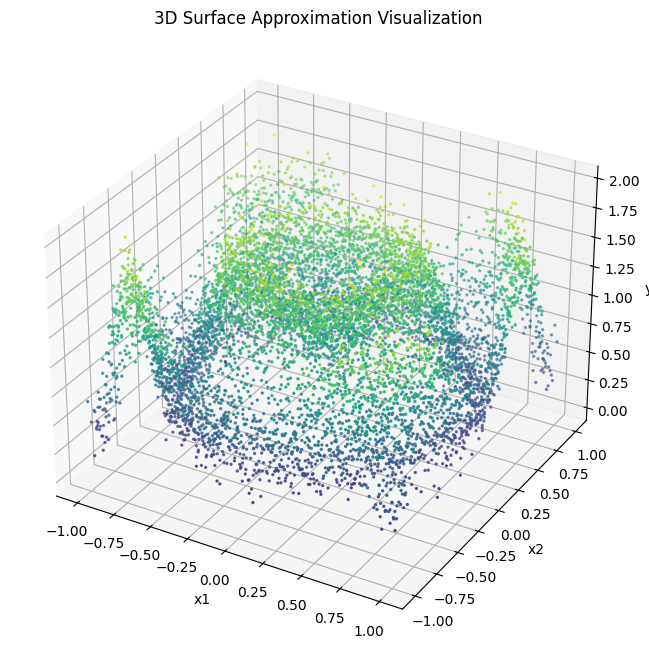

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the relationship between x1, x2 and y
ax.scatter(train_df['x1'], train_df['x2'], train_df['y'], c=train_df['y'], cmap='viridis', s=2)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title('3D Surface Approximation Visualization')
plt.show()

In [38]:
# See which feature is most like y
correlations = train_df.drop(columns=['id']).corr()['y'].abs().sort_values(ascending=False)
print(correlations)

y             1.000000
sr_feature    0.920508
r_te          0.916914
knn_pred      0.910854
wave_9_1      0.771146
wave_7_3      0.748598
r             0.345540
r_bin         0.337508
x2            0.011199
x1            0.002786
angle         0.000758
Name: y, dtype: float64


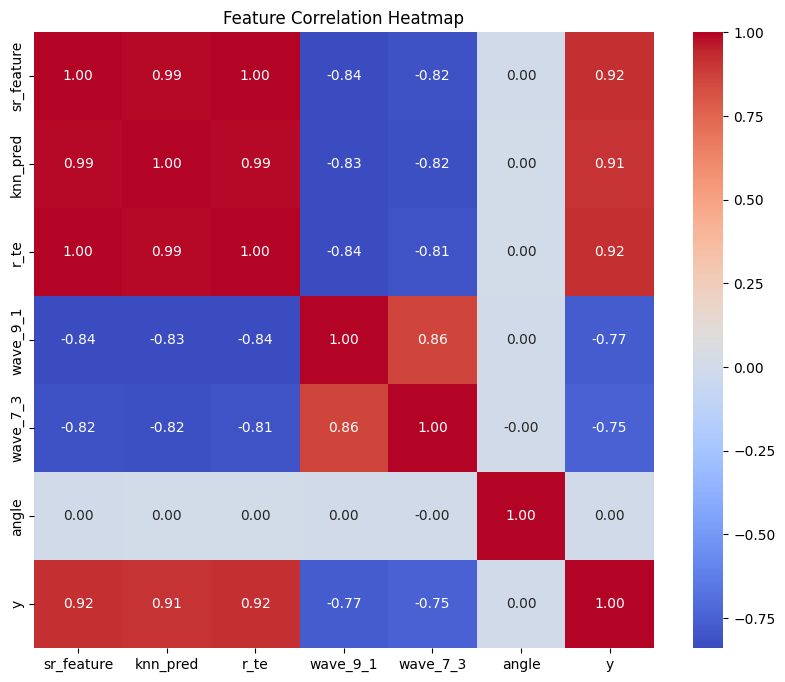

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the final features used and the target y
cols_to_plot = features_final + ['y']
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[cols_to_plot].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()